# Fit the final model and make predictions

In [1]:
library(magrittr)

## Prepare datasets

In [4]:
blacklist = readr::read_tsv('features/blacklist.tsv')$feature
feature_df = readr::read_tsv('features/transformed_features.tsv.bz2')

Parsed with column specification:
cols(
  feature = col_character()
)
Parsed with column specification:
cols(
  .default = col_double(),
  compound_id = col_character(),
  compound_name = col_character(),
  disease_id = col_character(),
  disease_name = col_character(),
  category = col_character(),
  status = col_integer()
)
See spec(...) for full column specifications.


In [5]:
summary(feature_df$prior_prob)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0000821 0.0000000 0.5185000 

In [6]:
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [7]:
feature_df = select(feature_df, -one_of(blacklist))

In [8]:
head(feature_df, 2)

compound_id,compound_name,disease_id,disease_name,category,status,prior_prob,prior_logit,degree_CpiwP,degree_CsdiC,⋯,degree_DgaG,degree_D<soD,degree_Dso>D,dwpc_CduftDduftCduftD,dwpc_CduftDso>D<soD,dwpc_CduftDso>D<soD<soD,dwpc_CduftDso>DduftCduftD,dwpc_CduftDso>Dso>D<soD,dwpc_CpiwPpiwCduftD,dwpc_CsdiCsdiCduftD
Q408524,cyclophosphamide,Q41861,hypertension,NA,0,0.5185,0.07391,-0.5943,-0.1692,⋯,7.8000,2.374,1.5320,31.97000,-0.03517,-0.04985,-0.02129,27.74000,-0.02087,-0.01579
Q408524,cyclophosphamide,Q221668,acute cystitis,NA,0,0.4364,-0.25580,-0.5943,-0.1692,⋯,-0.1422,1.462,-0.4215,-0.03286,-0.03517,-0.04985,-0.02129,-0.03444,-0.02087,-0.01579


In [9]:
train_df = filter(feature_df, prior_prob > 0)

X_train = train_df %>%
  dplyr::select(prior_logit, starts_with('degree_'), starts_with('dwpc_')) %>%
  as.matrix()
dim(X_train)

y_train = train_df$status

[1] 637894     17

In [10]:
summary(feature_df$prior_prob)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0000821 0.0000000 0.5185000 

In [11]:
sum(feature_df$prior_prob != 0)

[1] 637894

## Fit Model

In [12]:
lambda = 'lambda.1se'
penalty = ifelse(colnames(X_train) == 'prior_logit', 0, 1)

In [13]:
fit = hetior::glmnet_train(X = X_train, y = y_train, alpha = 0.2, s = lambda, cores = 10, seed = 0,
  penalty.factor=penalty, lambda.min.ratio=1e-8, nlambda=150, standardize=TRUE)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



[1] 0.002798113

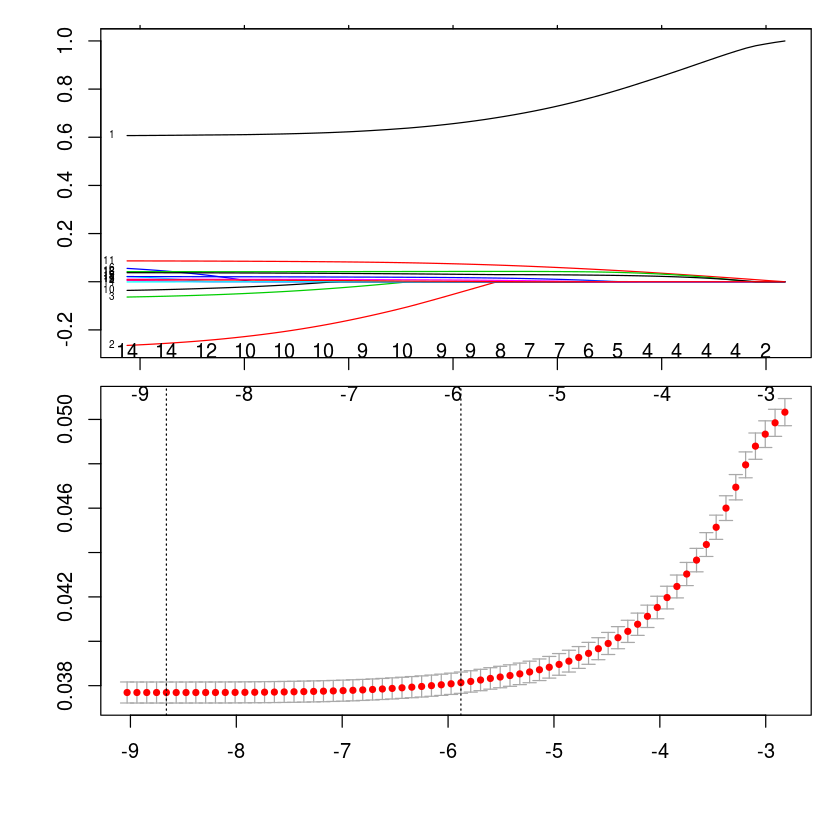

In [14]:
par(mfrow = c(2,1), oma = c(5,4,0,0) + 0.1, mar = c(0,0,1,1) + 0.1)
plot(fit$cv_model$glmnet.fit, xvar = "lambda", label = TRUE)
plot(fit$cv_model)
fit$cv_model[[lambda]]

In [15]:
# The coefficient for prior_logit should be around 1 for our approach to work well
dplyr::filter(fit$coef_df, feature == 'prior_logit')$coef

[1] 0.6628598

In [16]:
# Number of negative and positive coefficients
fit$coef_df %>%
  dplyr::filter(feature != 'intercept', zcoef != 0) %>%
  .[['zcoef']] %>% sign %>% table

.
-1  1 
 1  8 

In [17]:
# Sum of prior (should sum to the number of treatments)
sum(feature_df$prior_prob)

# Prevalence of positives as percent
scales::percent(mean(feature_df$status))

[1] 2968.972

[1] "0.00821%"

In [18]:
X_all = feature_df %>%
  dplyr::mutate(prior_logit = boot::logit(mean(status))) %>%
  dplyr::select(one_of(colnames(X_train))) %>%
  as.matrix()

y_predicted = hetior::glmnet_predict(fit$cv_model, X = X_all, s = lambda)
y_predicted %>% mean() %>% scales::percent()

[1] "0.0143%"

In [19]:
train_pred_df = train_df %>%
  dplyr::select(compound_id, disease_id) %>%
  dplyr::bind_cols(dplyr::data_frame(training_prediction = fit$y_pred))

predict_df = feature_df %>%
  dplyr::select(compound_id:prior_prob, starts_with('status')) %>%
  dplyr::mutate(prediction = y_predicted) %>%
  dplyr::left_join(train_pred_df) %>%
  dplyr::group_by(compound_id) %>%
  dplyr::mutate(compound_percentile = dplyr::cume_dist(prediction)) %>%
  dplyr::ungroup() %>%
  dplyr::group_by(disease_id) %>%
  dplyr::mutate(disease_percentile = dplyr::cume_dist(prediction)) %>%
  dplyr::ungroup() %>%
  dplyr::left_join(readr::read_tsv('../validate/validation-statuses.tsv'))

Joining, by = c("compound_id", "disease_id")
Parsed with column specification:
cols(
  compound_id = col_character(),
  compound_name = col_character(),
  disease_id = col_character(),
  disease_name = col_character(),
  n_trials = col_integer(),
  status_trials = col_integer(),
  status_drugcentral = col_integer()
)
Joining, by = c("compound_id", "compound_name", "disease_id", "disease_name")


In [20]:
predict_df %>%
  dplyr::arrange(desc(prediction)) %>%
  head(2)

compound_id,compound_name,disease_id,disease_name,category,status,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral
Q1215575,naproxen,Q62736,osteoarthritis,DM,1,0.04706,0.1483240,0.9237100,1,1.0000000,NA,NA,NA
Q186969,ibuprofen,Q62736,osteoarthritis,DM,1,0.05370,0.1446272,0.9280038,1,0.9997714,NA,NA,NA


## Calculate performance

In [21]:
get_metrics = function(params) {
  y_true_var = params$y_true_var
  y_pred_var = params$y_pred_var
  vtm_df = predict_df[, c(y_true_var, y_pred_var)] %>% na.omit()
  y_true = vtm_df[[1]]
  vtm = hetior::calc_vtms(y_true = y_true, y_pred = vtm_df[[2]], is_prob = T)
  dplyr::data_frame(
      y_true_var = y_true_var, y_pred_var = y_pred_var,
      n_pos = sum(y_true == 1), n_neg = sum(y_true == 0),
      auroc = vtm$auroc, auprc = vtm$auprc, tjur = vtm$tjur
  ) %>% return()
}

perf_df = tidyr::crossing(
  y_pred_var = c('prediction', 'compound_percentile', 'disease_percentile', 'training_prediction', 'prior_prob'),
  y_true_var = c('status', 'status_drugcentral', 'status_trials')
) %>%
  dplyr::rowwise() %>%
  dplyr::do(get_metrics(.))

perf_df

y_true_var,y_pred_var,n_pos,n_neg,auroc,auprc,tjur
status,compound_percentile,2969,36143767,0.2995384,5.279919e-05,-0.0017457033
status_drugcentral,compound_percentile,121,36143646,0.2327324,1.974276e-06,-0.0135742492
status_trials,compound_percentile,5159,36138608,0.1809249,7.990948e-05,-0.0155425771
status,disease_percentile,2969,36143767,0.5095883,7.406716e-05,0.1929468350
status_drugcentral,disease_percentile,121,36143646,0.3630707,2.354576e-06,0.0091260072
status_trials,disease_percentile,5159,36138608,0.3012514,9.150158e-05,-0.1335562565
status,prediction,2969,36143767,0.8943534,2.333283e-01,0.0069323805
status_drugcentral,prediction,121,36143646,0.6842102,6.585197e-04,0.0007968921
status_trials,prediction,5159,36138608,0.5182319,8.206027e-03,0.0005154359
status,prior_prob,2969,36143767,0.9971545,4.169797e-02,0.0260275562


## Write results to TSVs

In [22]:
perf_df %>% readr::write_tsv('predictions/performance.tsv')
fit$coef_df %>% readr::write_tsv('model/coefficient.tsv')
predict_df %>% readr::write_tsv('predictions/probabilities.tsv', na = '')

## Write an xlsx with top predictions

In [50]:
# Read trials
url = 'https://github.com/dhimmel/clintrials/blob/7c65dec7b69322ca2f8ba2b170c1b3dbd92ebff8/data/DrugBank-DO-slim.tsv?raw=true'
trial_df = readr::read_tsv(url) %>%
  dplyr::group_by(compound_id, disease_id) %>%
  dplyr::summarize(n_trials = n()) %>%
  dplyr::ungroup()

# Extract most pertinent columns and top predictions
top_df = predict_df %>%
  dplyr::arrange(desc(prediction)) %>%
  dplyr::select(compound_id, disease_id, compound_name, disease_name, category, prediction, compound_percentile, disease_percentile, prior_prob) %>%
  dplyr::filter((prediction > 0.01)) %>%
  dplyr::left_join(trial_df) %>%
  dplyr::mutate(n_trials = ifelse(is.na(n_trials), 0, n_trials))

compound_hyperlink = setNames(paste0('http://www.drugbank.ca/drugs/', top_df$compound_id), top_df$compound_name)
disease_hyperlink = setNames(paste0('http://www.disease-ontology.org/?id=', top_df$disease_id), top_df$disease_name)
class(compound_hyperlink) = 'hyperlink'
class(disease_hyperlink) = 'hyperlink'
top_df %<>% dplyr::select(-ends_with('_id'))

# Convert columns to percent for pretty formatting
percent_cols = c('prediction', 'compound_percentile', 'disease_percentile', 'prior_prob')
for (percent_col in percent_cols) {
  class(top_df[[percent_col]]) = 'percentage'
}

# Write to an excel file
workbook = openxlsx::createWorkbook('Project Rephetio')
sheet = 'Top Predictions'
openxlsx::addWorksheet(workbook, sheet)
openxlsx::writeDataTable(workbook, sheet, top_df)
openxlsx::writeData(workbook, sheet, compound_hyperlink, startCol = 1, startRow = 2)
openxlsx::writeData(workbook, sheet, disease_hyperlink, startCol = 2, startRow = 2)
openxlsx::freezePane(workbook, sheet, firstRow = T)
openxlsx::setColWidths(workbook, sheet, cols=1:7, widths='auto')
openxlsx::saveWorkbook(workbook, './predictions/top-predictions.xlsx', overwrite = T)

Joining by: c("compound_id", "disease_id")
Warning message:
: Overwriting existing cell data.Warning message:
: Overwriting existing cell data.